# Imports

In [3]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('precision', 3)

# Load Data

In [5]:
clean_data = pd.read_pickle('dataset/Automobile-processed.pkl.bz2', compression='bz2')

X = clean_data.drop(columns=['price'])
Y = clean_data.price

X_train = pd.read_pickle('dataset/Automobile-processed-X_train.pkl.bz2', compression='bz2')
Y_train = pd.read_pickle('dataset/Automobile-processed-Y_train.pkl.bz2', compression='bz2')
X_test  = pd.read_pickle('dataset/Automobile-processed-X_test.pkl.bz2', compression='bz2')
Y_test  = pd.read_pickle('dataset/Automobile-processed-Y_test.pkl.bz2', compression='bz2')

# Auxiliar Functions

In [6]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

def plotRelativeError(pred_data, actual_data):
  x = np.linspace(start=1, stop=len(actual_data), num=len(actual_data));
  plt.rcParams['figure.figsize']=(7,4);
  plt.title("Relative Error");
  plt.stem(x, abs(pred_data - actual_data)/actual_data, linefmt='grey', markerfmt='D', bottom=0);
  plt.grid(True)
  plt.ylim((0,1))
  plt.show();

def plotAbsoluteError(pred_data, actual_data):
  x = np.linspace(start=1, stop=len(actual_data), num=len(actual_data));
  plt.rcParams['figure.figsize']=(7,4);
  plt.title("Absolute Error");
  plt.scatter(x, pred_data);
  plt.scatter(x, actual_data);
  plt.grid(True)
  plt.show();

def getModelInfo(model, x, y):
  pred = model.predict(x);
  R2score = r2_score(y,pred);

  plotRelativeError(pred, y);
  plotAbsoluteError(pred, y);
  print("R2 Score: " + str(R2score));

def evalModelWithKFold(modelito, myX, myY, myK):
    kfold = KFold(n_splits=myK,shuffle=True,random_state=42)
    total_score = 0
    for train_indices, test_indices in kfold.split(myX.values):
        modelito.fit(myX.values[train_indices], myY[train_indices]);
        
        pred = modelito.predict(myX.values[test_indices]);
        R2score = r2_score(myY[test_indices], pred);
        total_score += R2score / myK;
        plotRelativeError(pred, myY[test_indices]);
        plotAbsoluteError(pred, myY[test_indices]);
        print("R2 Score: " + str(R2score));
        print("---------------------------------------------------------")
        
        
    print("Mean R2 Score: " + str(total_score))    

# Linear Regression

In [7]:
linearRegressor = LinearRegression(normalize=False);
linearRegressor.fit(X_train,Y_train);

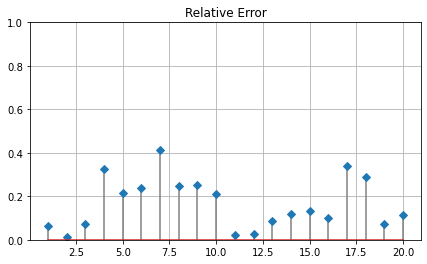

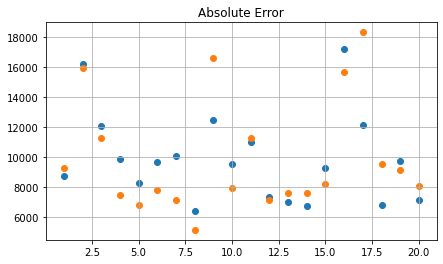

R2 Score: 0.6486287166842399
---------------------------------------------------------


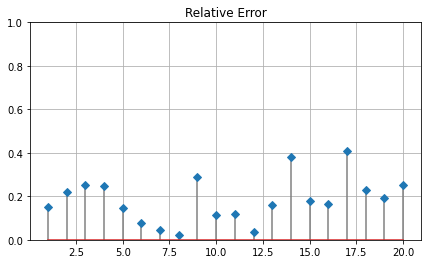

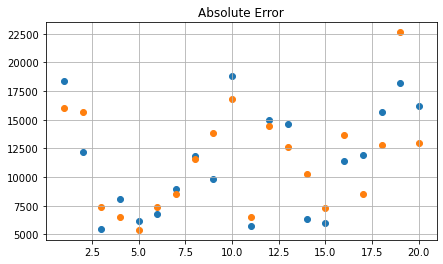

R2 Score: 0.6727748359074279
---------------------------------------------------------


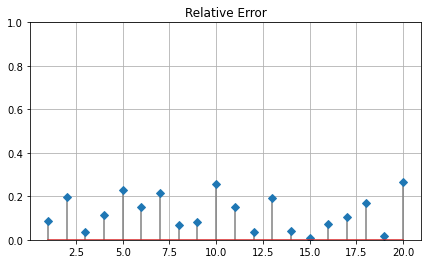

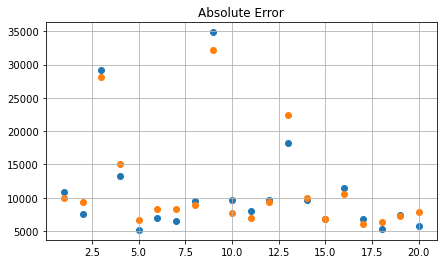

R2 Score: 0.9500178322798787
---------------------------------------------------------


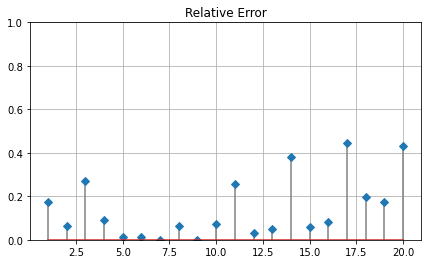

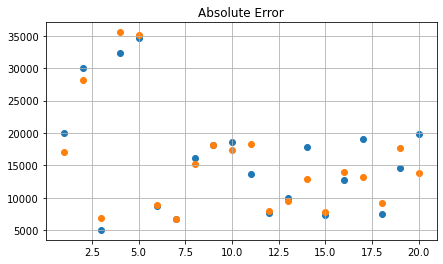

R2 Score: 0.8839848939103079
---------------------------------------------------------


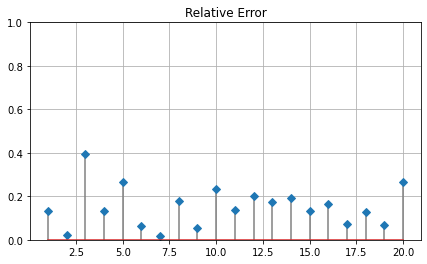

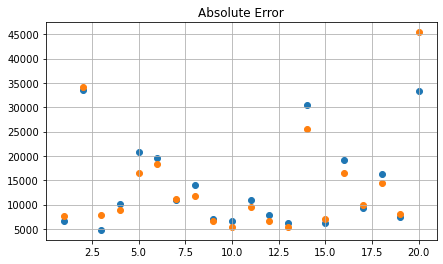

R2 Score: 0.890396755988963
---------------------------------------------------------


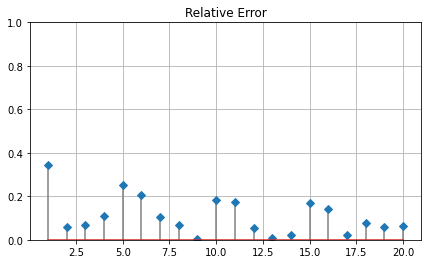

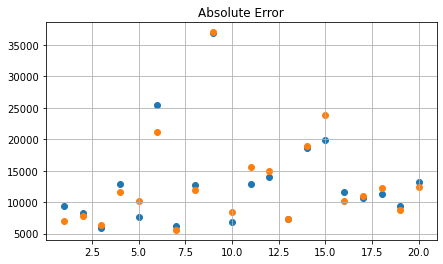

R2 Score: 0.9392326227138232
---------------------------------------------------------


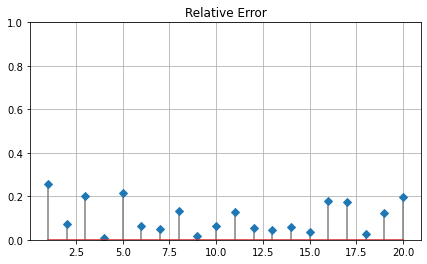

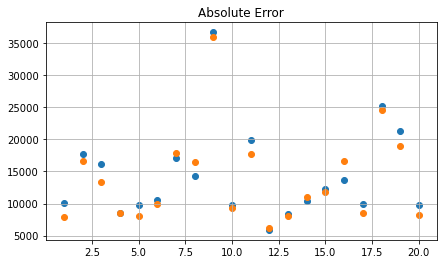

R2 Score: 0.9508643874875997
---------------------------------------------------------


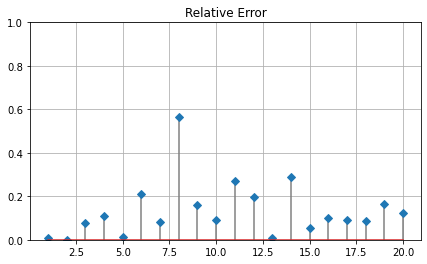

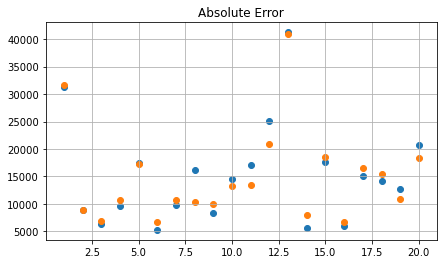

R2 Score: 0.9346630083337633
---------------------------------------------------------


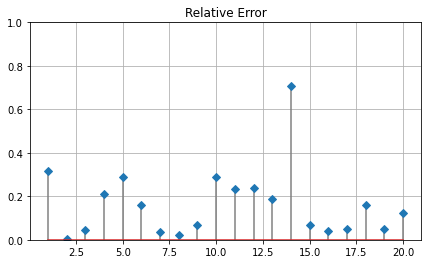

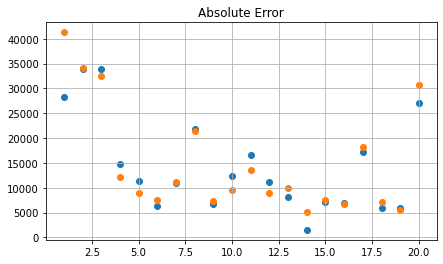

R2 Score: 0.8938090681537266
---------------------------------------------------------


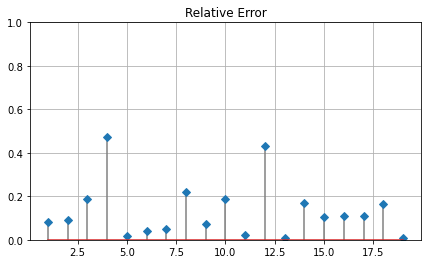

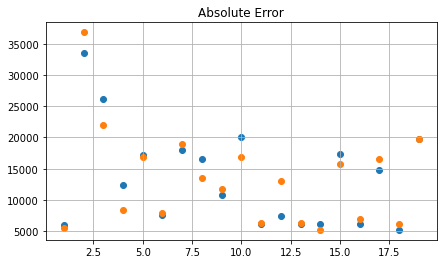

R2 Score: 0.9072781601372619
---------------------------------------------------------
Mean R2 Score: 0.8671650281596992


In [8]:
evalModelWithKFold(linearRegressor, X, Y, 10);

# Ridge

In [9]:
# lambdas = np.linspace(start=0.18,stop=0.20,num=5000);
lambdas = [0.1939107821564313]
ridge= RidgeCV(alphas=lambdas, scoring='neg_mean_absolute_error', cv=KFold(n_splits=10,shuffle=True,random_state=42));
ridge.fit(X_train,Y_train);
print(ridge.alpha_);

0.1939107821564313


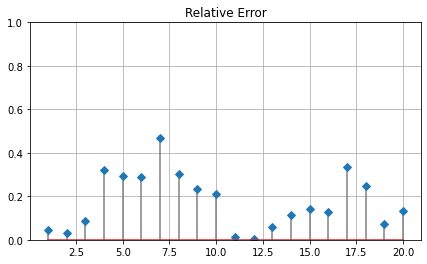

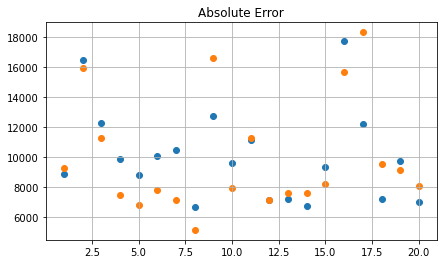

R2 Score: 0.6354503029632648
---------------------------------------------------------


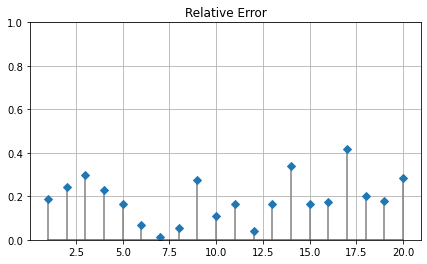

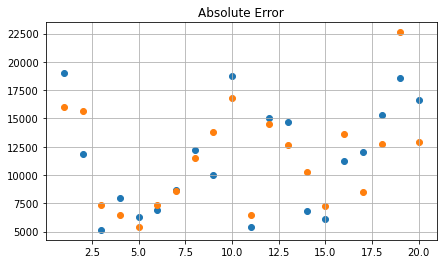

R2 Score: 0.6668418110104702
---------------------------------------------------------


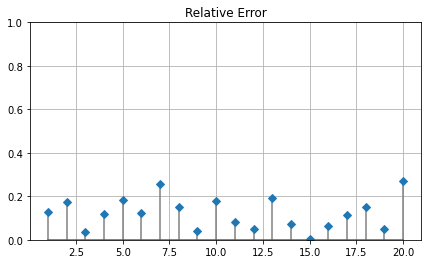

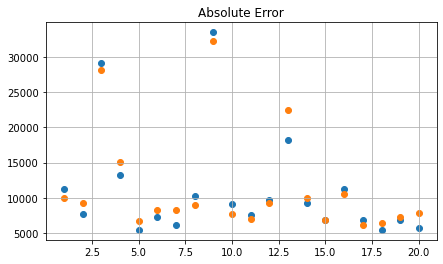

R2 Score: 0.9556241586297792
---------------------------------------------------------


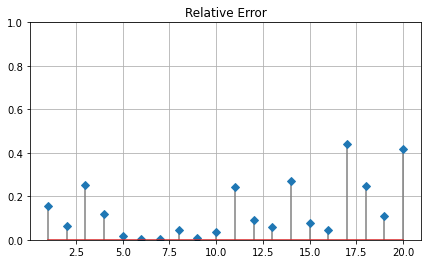

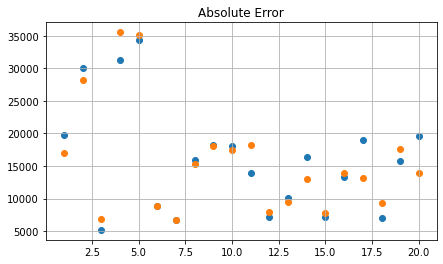

R2 Score: 0.8969873316881187
---------------------------------------------------------


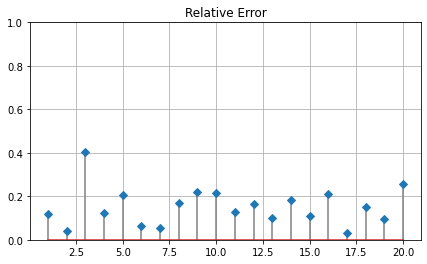

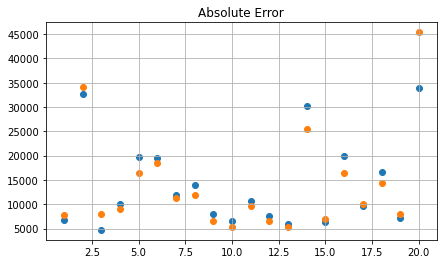

R2 Score: 0.8972122238158624
---------------------------------------------------------


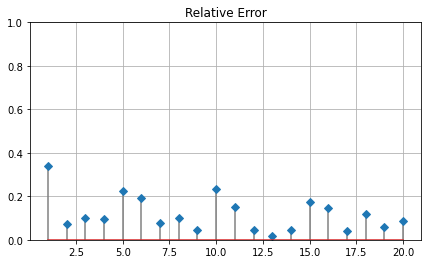

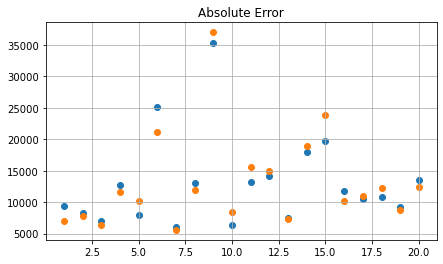

R2 Score: 0.9364131953329673
---------------------------------------------------------


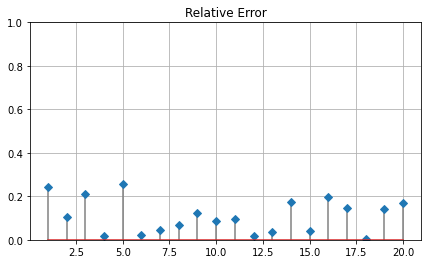

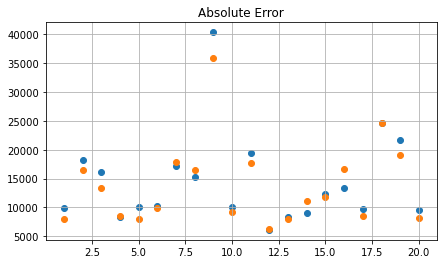

R2 Score: 0.9298251523274712
---------------------------------------------------------


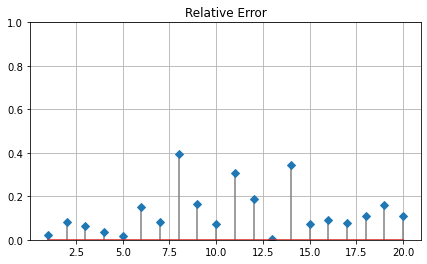

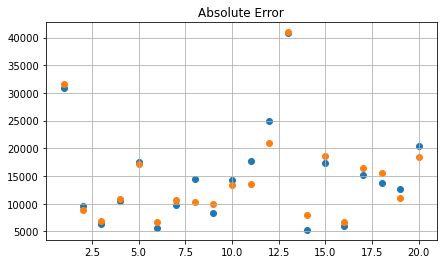

R2 Score: 0.9449014820078435
---------------------------------------------------------


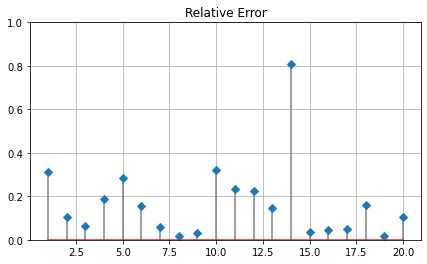

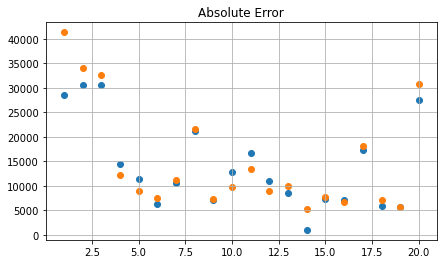

R2 Score: 0.8907880571418831
---------------------------------------------------------


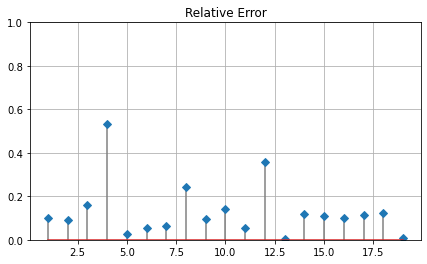

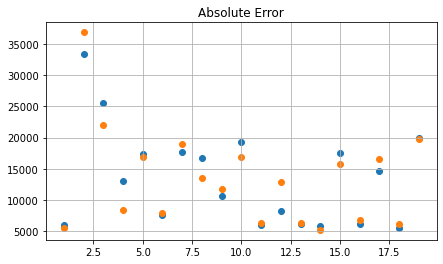

R2 Score: 0.915433311326034
---------------------------------------------------------
Mean R2 Score: 0.8669477026243695


In [10]:
evalModelWithKFold(ridge, X, Y, 10);

# Lasso

In [11]:
lambdas = 10**np.arange(1,2,0.001)
# lambdas = [0.1938938938938939]
lasso = LassoCV(alphas=lambdas, cv=KFold(n_splits=10,shuffle=True,random_state=42), random_state=42);
lasso.fit(X_train,Y_train);
print(lasso.alpha_);

22.908676527675638


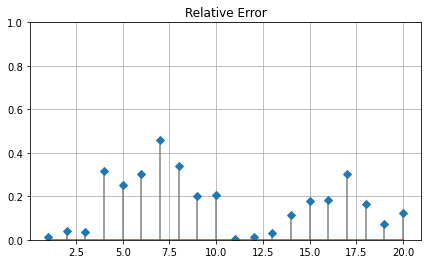

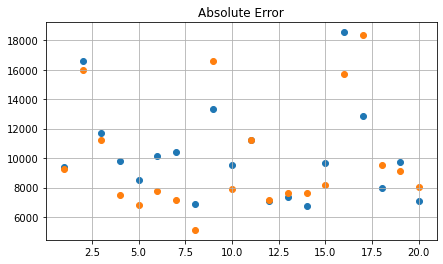

R2 Score: 0.6776957191716806
---------------------------------------------------------


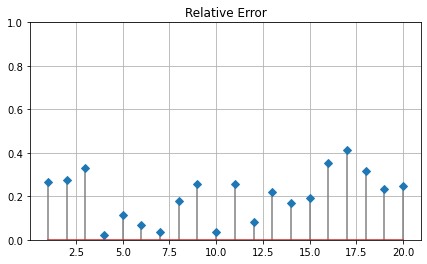

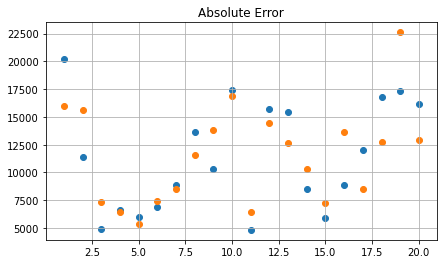

R2 Score: 0.5522538501349925
---------------------------------------------------------


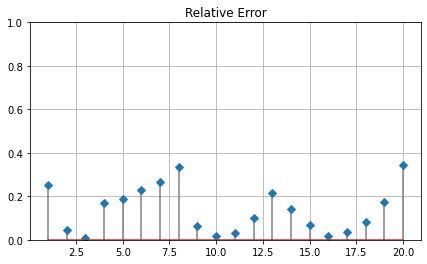

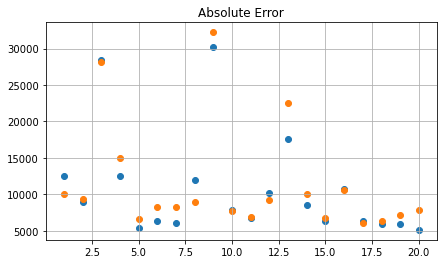

R2 Score: 0.9322291497836361
---------------------------------------------------------


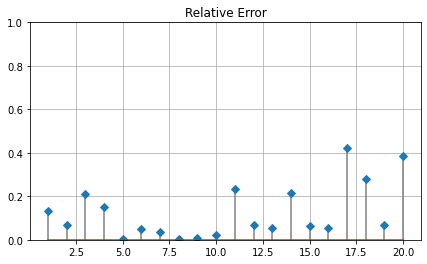

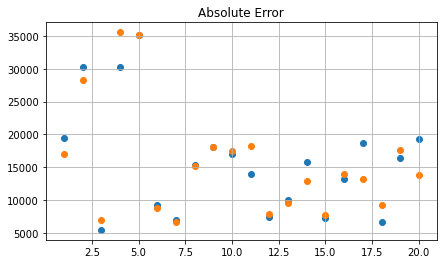

R2 Score: 0.901556238617069
---------------------------------------------------------


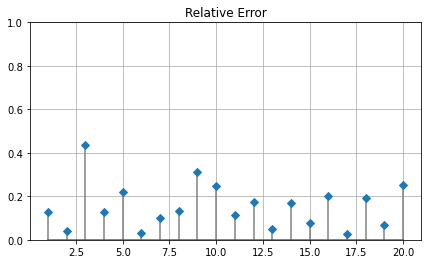

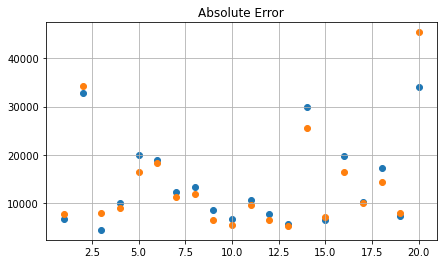

R2 Score: 0.898181869673611
---------------------------------------------------------


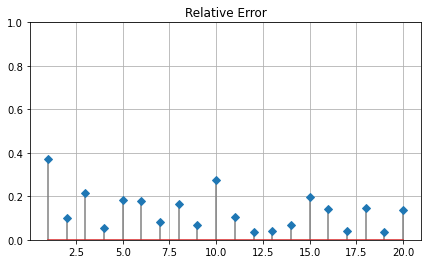

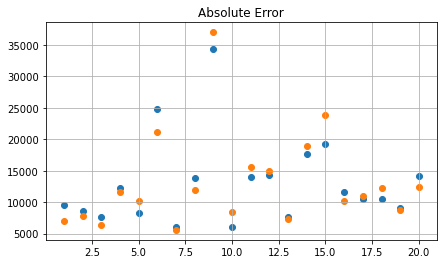

R2 Score: 0.9265861355997254
---------------------------------------------------------


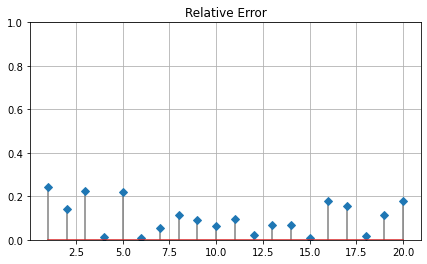

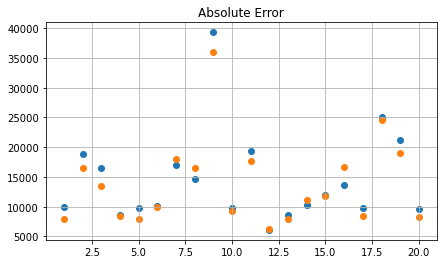

R2 Score: 0.9402699530297212
---------------------------------------------------------


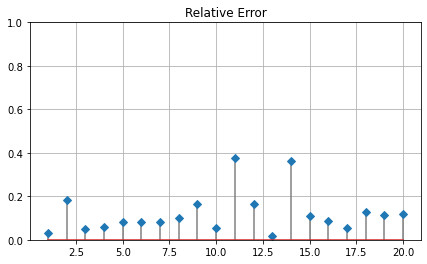

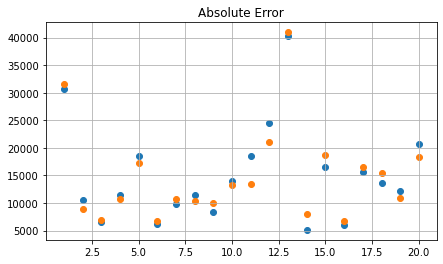

R2 Score: 0.9479109285699078
---------------------------------------------------------


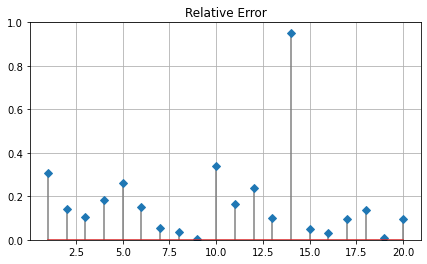

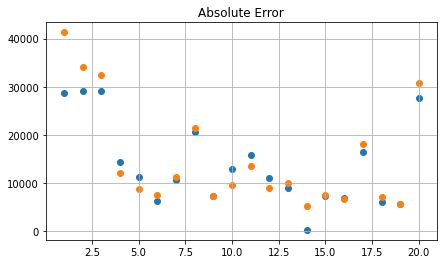

R2 Score: 0.8839136577401261
---------------------------------------------------------


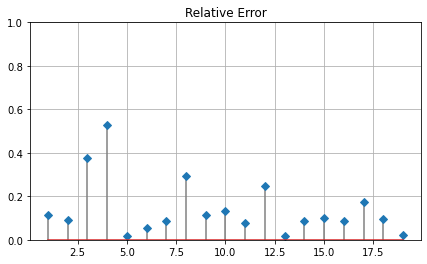

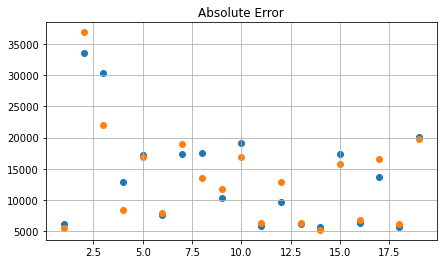

R2 Score: 0.8677046640830065
---------------------------------------------------------
Mean R2 Score: 0.8528302166403475


In [12]:
evalModelWithKFold(lasso, X, Y, 10);

# KNN

In [13]:
knn_params = {'n_neighbors' : [n for n in range(1,45)], 
              'weights' : ['uniform', 'distance'],
              'p' : [1, 2],
              'leaf_size' : [n for n in range(1,40, 1)],
              'metric' : ['euclidean', 'manhattan', 'chebyshev', 'mahalanobis']}

knn = GridSearchCV(estimator= KNeighborsRegressor(n_jobs=-1),
                   param_grid= knn_params,
                   scoring= 'neg_mean_absolute_error',
                   n_jobs= -1,
                   verbose = 4);

knn.fit(X_train,Y_train);

Fitting 5 folds for each of 27456 candidates, totalling 137280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 832 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 2200 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 5214 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 7728 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 9364 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 13176 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 21960 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 33120 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 45480 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 58992 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 73704 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 89568 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 106632 ta

In [17]:
best_knn = knn.best_estimator_
best_knn
#best_knn = KNeighborsRegressor(leaf_size=2, metric='manhattan', n_jobs=-1, n_neighbors=2, p=1, weights='distance')
#best_knn.fit(X_train,Y_train);

KNeighborsRegressor(leaf_size=2, metric='manhattan', n_jobs=-1, n_neighbors=2,
                    p=1, weights='distance')

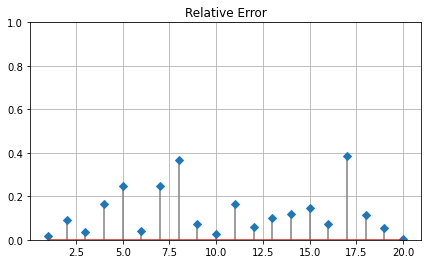

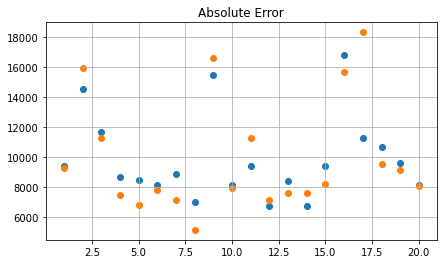

R2 Score: 0.7289065204618753
---------------------------------------------------------


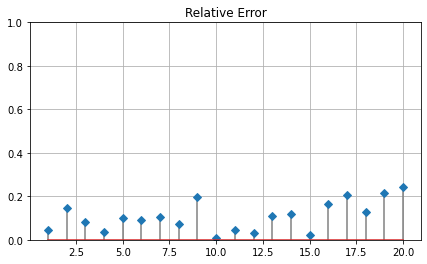

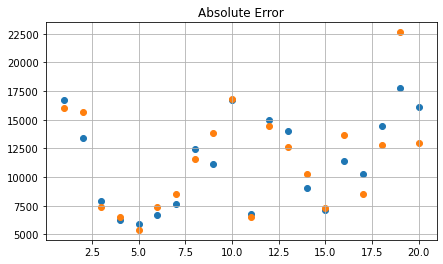

R2 Score: 0.8289634735076284
---------------------------------------------------------


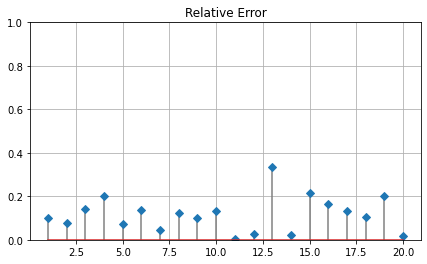

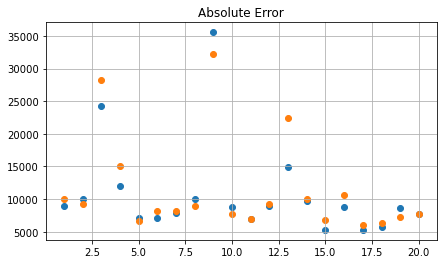

R2 Score: 0.8990084985654874
---------------------------------------------------------


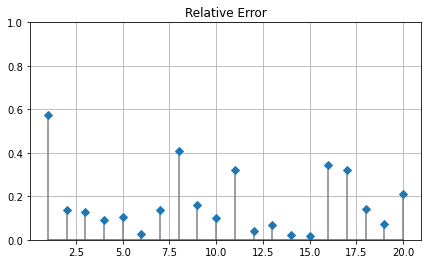

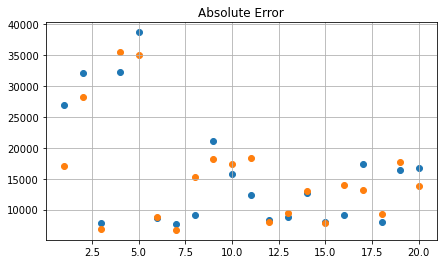

R2 Score: 0.7998811585310364
---------------------------------------------------------


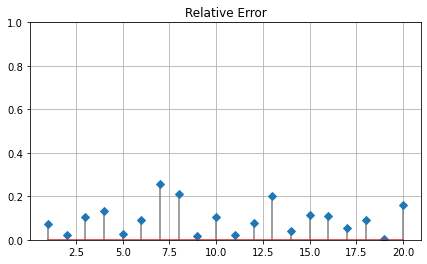

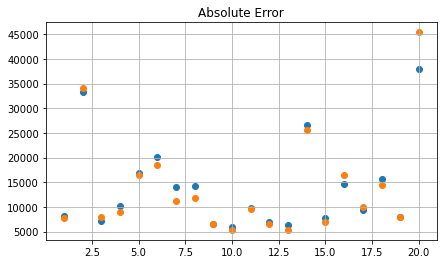

R2 Score: 0.9594370930882343
---------------------------------------------------------


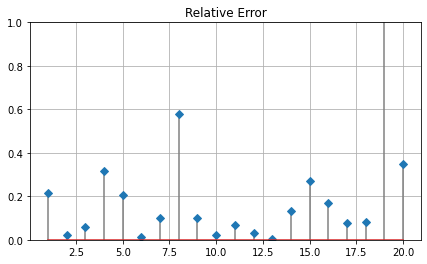

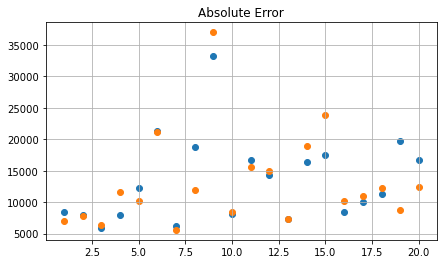

R2 Score: 0.7436077031382344
---------------------------------------------------------


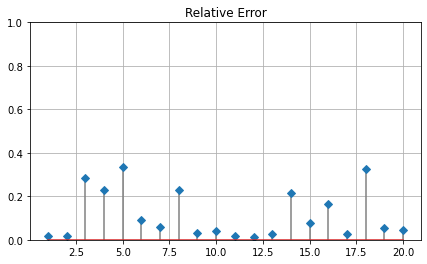

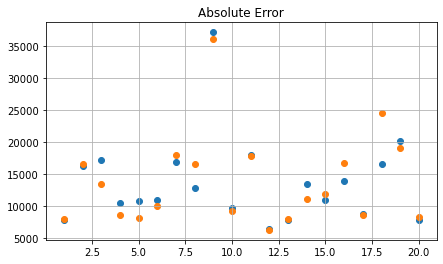

R2 Score: 0.8754879447776818
---------------------------------------------------------


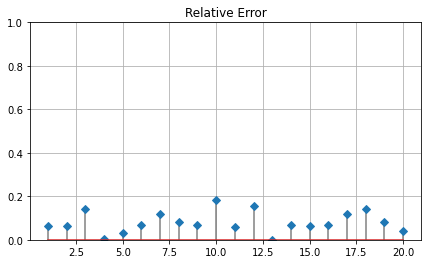

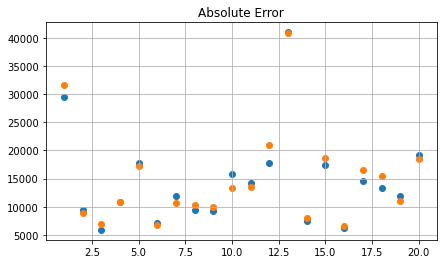

R2 Score: 0.9729523341582669
---------------------------------------------------------


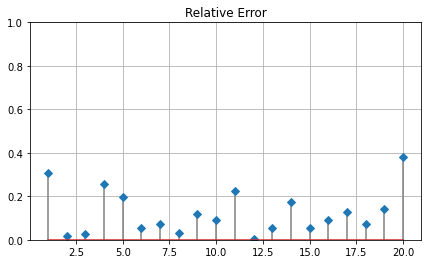

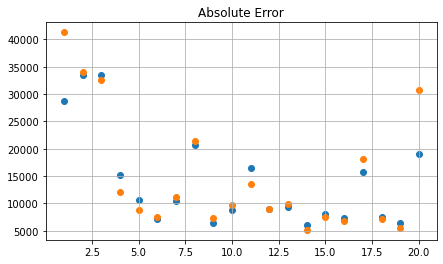

R2 Score: 0.857022491404197
---------------------------------------------------------


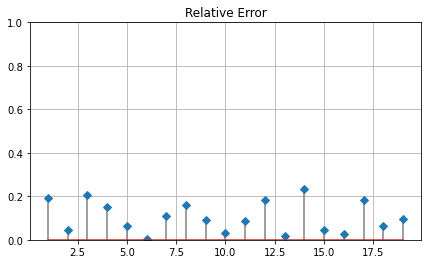

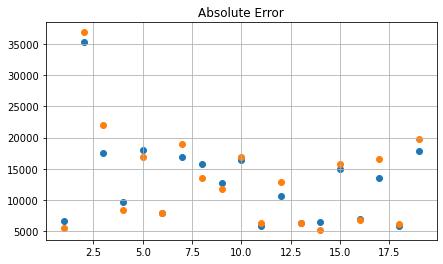

R2 Score: 0.9479065840621758
---------------------------------------------------------
Mean R2 Score: 0.8613173801694818


In [15]:
evalModelWithKFold(best_knn, X, Y, 10);

# MLP Regressor

In [18]:
# Create diferent sizes to test:

sizes = [[i for i in range(1,30)]]
sizes = sizes + [[i,i] for i in range(1,30)]
sizes = sizes + [[i,i,i] for i in range(1,30)]

# Create the model to use
param_grid = {'alpha' : (0.00001, 0.0001, 0.001, 0.01, 0.1),
              'hidden_layer_sizes': sizes, 
              'activation': ('identity', 'relu', 'logistic', 'tanh'),
              'learning_rate_init':[0.005,0.05,0.001]}

model_nnet = GridSearchCV(estimator= MLPRegressor(max_iter=10000,
                                                  solver='adam',
                                                  learning_rate='adaptive',
                                                  random_state=42),
                          
                          scoring= 'neg_mean_squared_error',
                          param_grid= param_grid,
                          n_jobs=-1,
                          cv=KFold(n_splits=10,shuffle=True,random_state=42),
                          verbose = 4);

model_nnet.fit(X_train,Y_train);

Fitting 10 folds for each of 3540 candidates, totalling 35400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1177 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1955 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 2381 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 2846 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 3745 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 4308 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 4950 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 6002 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 6754 tasks      | e

In [19]:
print(model_nnet.best_estimator_)
print(model_nnet.best_params_)

MLPRegressor(alpha=0.01, hidden_layer_sizes=[14, 14, 14],
             learning_rate='adaptive', max_iter=10000, random_state=42)
{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': [14, 14, 14], 'learning_rate_init': 0.001}


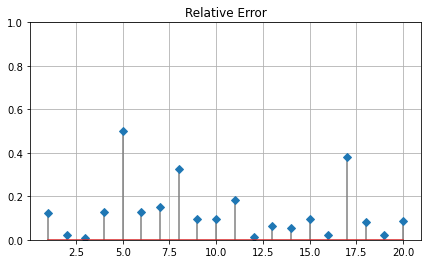

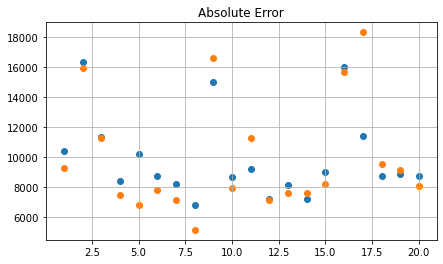

R2 Score: 0.7173217261683704
---------------------------------------------------------


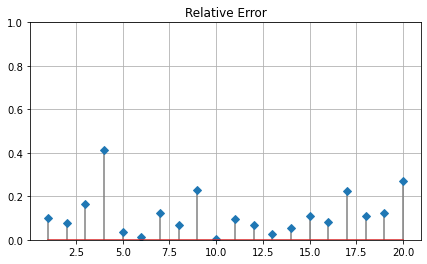

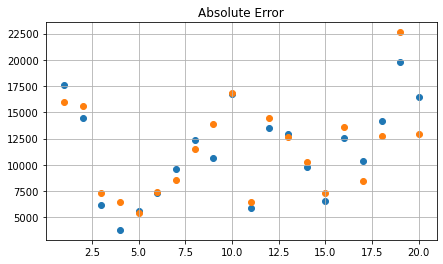

R2 Score: 0.855923158736204
---------------------------------------------------------


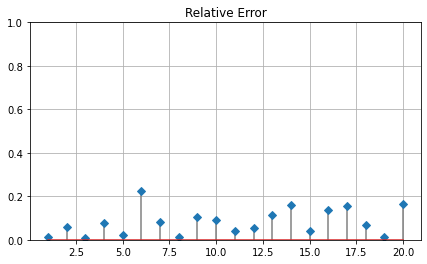

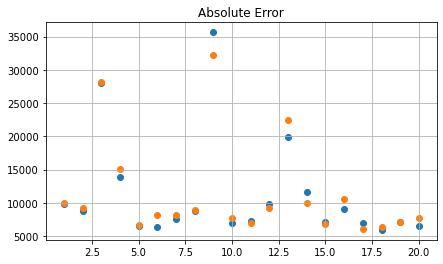

R2 Score: 0.9696088706196432
---------------------------------------------------------


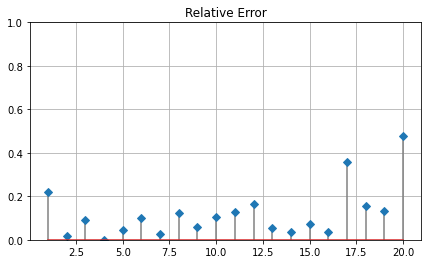

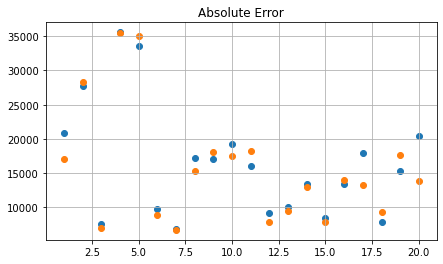

R2 Score: 0.9215761064334959
---------------------------------------------------------


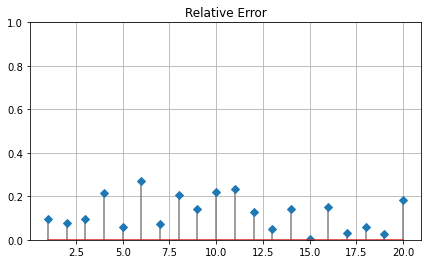

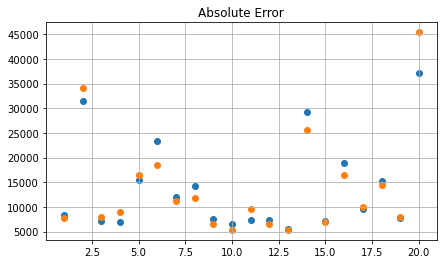

R2 Score: 0.9306221852079828
---------------------------------------------------------


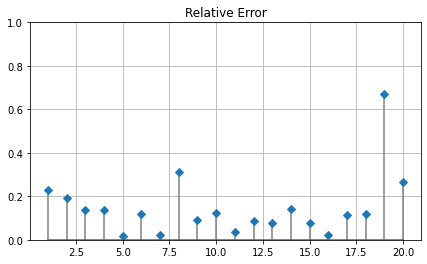

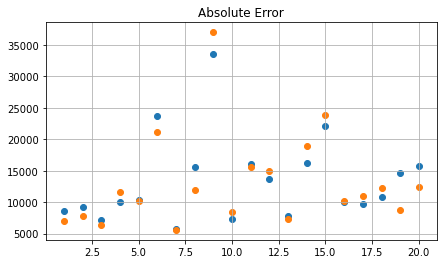

R2 Score: 0.9028925913936288
---------------------------------------------------------


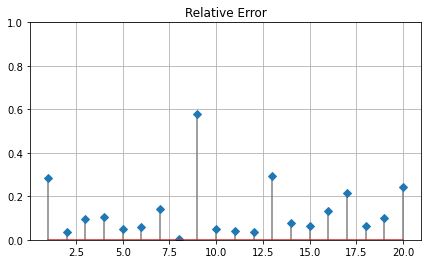

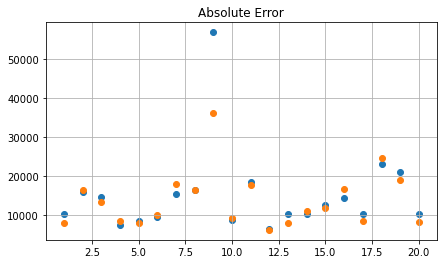

R2 Score: 0.5214774667796218
---------------------------------------------------------


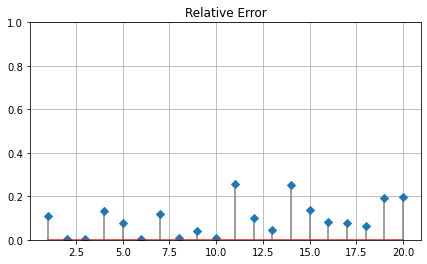

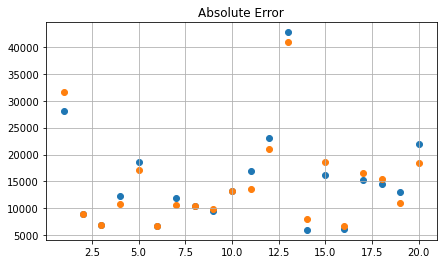

R2 Score: 0.9516243401610393
---------------------------------------------------------


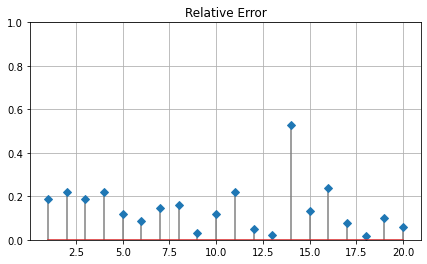

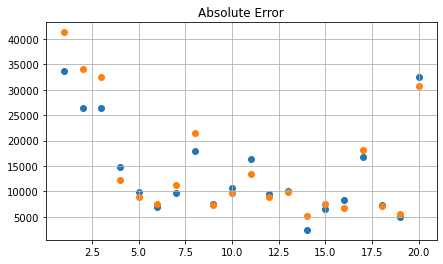

R2 Score: 0.9118167919032558
---------------------------------------------------------


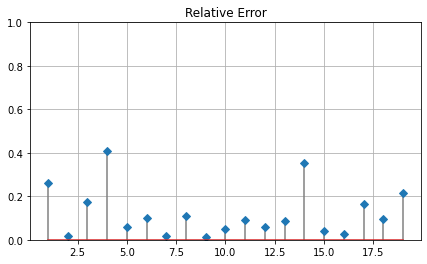

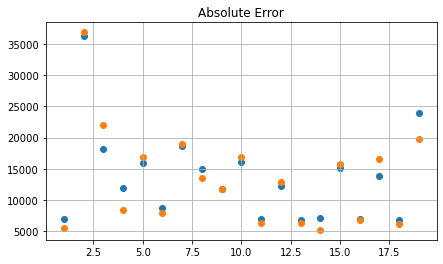

R2 Score: 0.9419027670019047
---------------------------------------------------------
Mean R2 Score: 0.8624766004405147


In [20]:
model_nnet_best = model_nnet.best_estimator_
evalModelWithKFold(model_nnet_best, X, Y, 10)

# Random Forest

In [22]:
param_grid = {'n_estimators' : [n for n in range(50,1000,10)],
              'min_samples_leaf': [0.12, 0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 4, 5, 10, 15, 20]}

random_forest = GridSearchCV(estimator= RandomForestRegressor(max_depth=6,
                                                              random_state=42, 
                                                              n_jobs=-1),
                             scoring= 'neg_mean_squared_error',
                             param_grid= param_grid,
                             n_jobs=-1,
                             cv=KFold(n_splits=10,shuffle=True,random_state=42),
                             verbose = 4);

random_forest.fit(X_train, Y_train);

Fitting 10 folds for each of 1330 candidates, totalling 13300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1177 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 2941 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4117 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 4778 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 5489 tasks      | e

In [23]:
random_forest.best_estimator_

RandomForestRegressor(max_depth=6, min_samples_leaf=2, n_jobs=-1,
                      random_state=42)

In [24]:
random_forest.best_params_

{'min_samples_leaf': 2, 'n_estimators': 100}

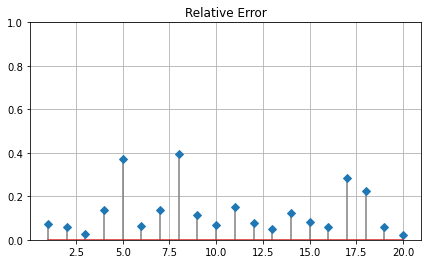

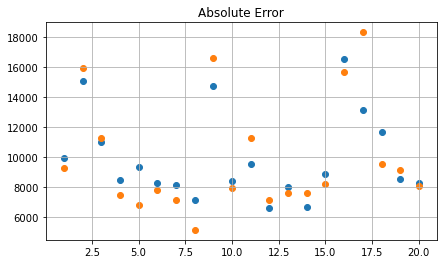

R2 Score: 0.795190562661179
---------------------------------------------------------


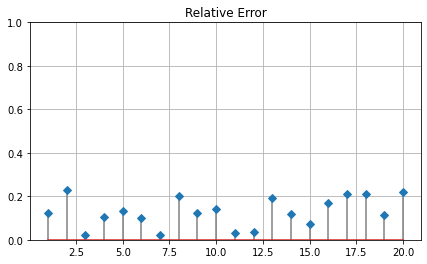

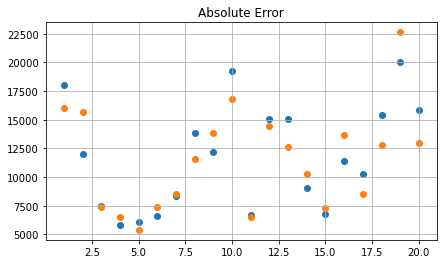

R2 Score: 0.8091529805204378
---------------------------------------------------------


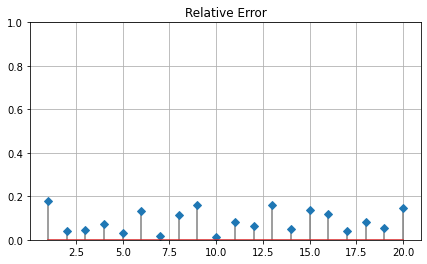

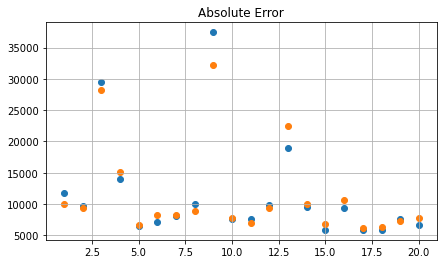

R2 Score: 0.949206968965373
---------------------------------------------------------


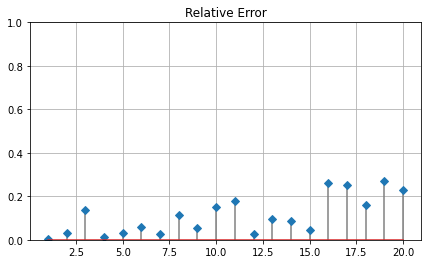

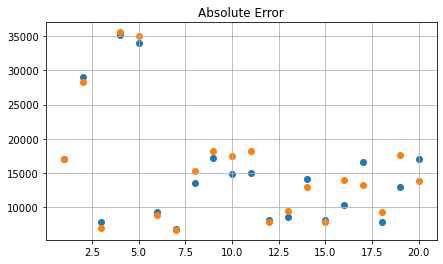

R2 Score: 0.9372783693329184
---------------------------------------------------------


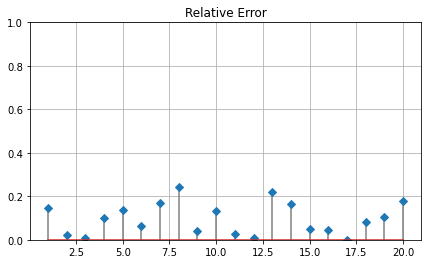

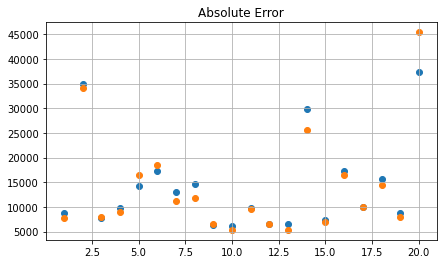

R2 Score: 0.9471303013192469
---------------------------------------------------------


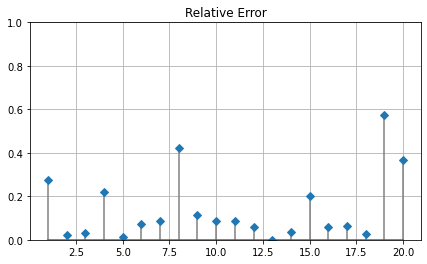

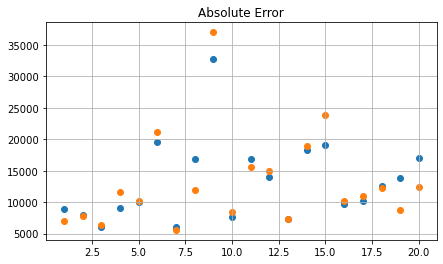

R2 Score: 0.878132374564701
---------------------------------------------------------


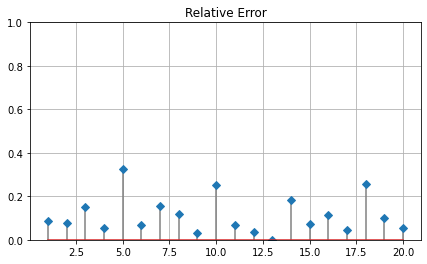

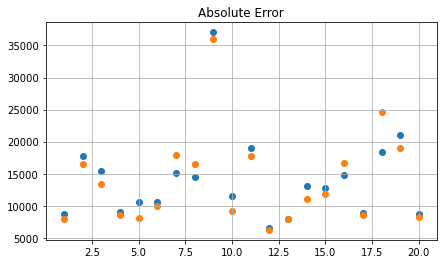

R2 Score: 0.9141177008707941
---------------------------------------------------------


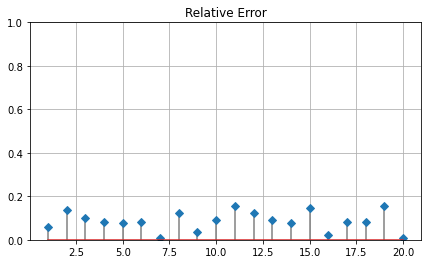

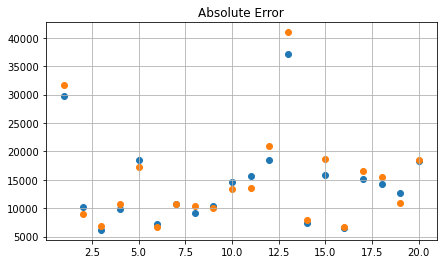

R2 Score: 0.9637826591941572
---------------------------------------------------------


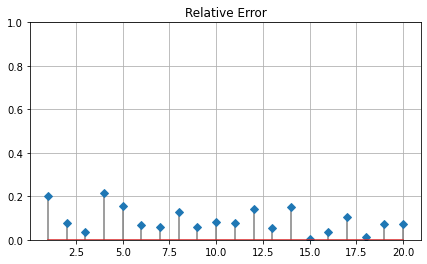

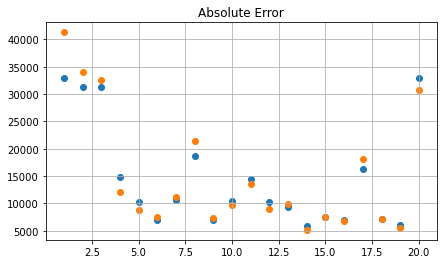

R2 Score: 0.9528423953863084
---------------------------------------------------------


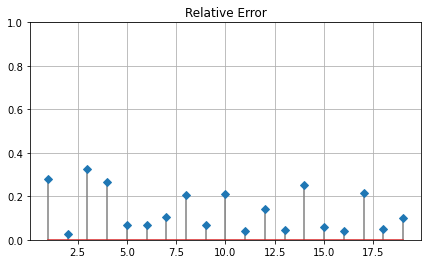

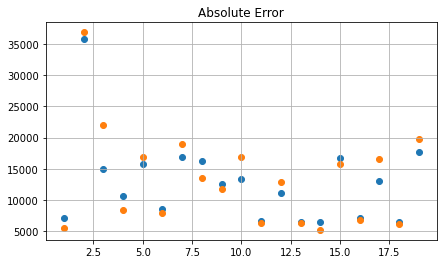

R2 Score: 0.9028567517482611
---------------------------------------------------------
Mean R2 Score: 0.9049691064563377


In [25]:
evalModelWithKFold(random_forest.best_estimator_, X, Y, 10)

# Load/Save Models

In [26]:
# Save to Pickle
import pickle
version = 2
pickle.dump( linearRegressor, open( "models/linearRegressor_v" + str(version) + ".pkl", "wb" ) )
pickle.dump( ridge,           open( "models/ridge_v" + str(version) + ".pkl", "wb" ) )
pickle.dump( lasso,           open( "models/lasso_v" + str(version) + ".pkl", "wb" ) )
pickle.dump( best_knn,        open( "models/best_knn_v" + str(version) + ".pkl", "wb" ) )
pickle.dump( model_nnet_best, open( "models/model_nnet_v" + str(version) + ".pkl", "wb" ) )

# Load from Pickle
linearRegressor = pickle.load( open( "models/linearRegressor_v1.pkl", "rb" ) )
ridge =           pickle.load( open( "models/ridge_v1.pkl", "rb" ) )
lasso =           pickle.load( open( "models/lasso_v1.pkl", "rb" ) )
best_knn =        pickle.load( open( "models/best_knn_v1.pkl", "rb" ) )
model_nnet_best =      pickle.load(open( "models/model_nnet_v1.pkl", "rb" ))